<a href="https://colab.research.google.com/github/anggundisanasini/ai-ml-stroke-analysis/blob/main/09011382328143_Anggun_Suci_Salsabila_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#UAS KECERDASAN  BUATAN  

ANGGUN SUCI SALSABILA (09011382328143)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


berikut adalah library yang akan dipakai dalam tugas ini

## PEMILIHAN DATASET

In [ ]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv') #dari kaggle https://www.kaggle.com/datasets/aouatifcherdid/healthcare-dataset-stroke-data
df.sample(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1528,11770,Female,25.00,0,0,Yes,Govt_job,Urban,93.23,NaN,smokes,0
3274,69487,Female,79.00,0,0,Yes,Self-employed,Urban,57.77,24.1,formerly smoked,0
3170,39322,Male,18.00,0,0,No,Private,Urban,80.59,23.0,Unknown,0
2030,38920,Male,0.48,0,0,No,children,Urban,73.02,NaN,Unknown,0
209,33454,Female,63.00,0,0,Yes,Govt_job,Rural,106.58,23.9,Unknown,1


Kode `df = pd.read_csv('healthcare-dataset-stroke-data.csv')` digunakan untuk membaca file CSV dan memasukkannya ke dalam DataFrame bernama *df*, sehingga data dapat diolah menggunakan Pandas. Setelah data berhasil dimuat, perintah `df.sample(5)` digunakan untuk menampilkan lima baris data secara acak dari DataFrame. Tujuannya adalah untuk melihat contoh isi dataset dan memastikan bahwa data sudah terbaca dengan benar.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Perintah `df.info()` digunakan untuk menampilkan ringkasan informasi mengenai DataFrame secara keseluruhan. Dari output yang ditampilkan, terlihat bahwa DataFrame memiliki **5110 baris dan 12 kolom**, masing-masing menunjukkan data pasien dengan berbagai atribut seperti usia, jenis kelamin, tekanan darah tinggi, penyakit jantung, dan lainnya. Pada setiap kolom ditampilkan jumlah data yang tidak kosong (non-null), tipe datanya, serta karakteristik lain yang membantu memahami struktur dataset. Hampir semua kolom memiliki data lengkap, namun kolom **bmi** hanya memiliki 4909 data sehingga terdapat nilai yang hilang (missing values). Selain itu, jenis data yang digunakan terdiri dari **int64**, **float64**, dan **object**, yang menunjukkan campuran data numerik dan kategorikal. Informasi ini penting untuk melihat kondisi awal dataset, termasuk apakah terdapat data yang hilang dan apakah tipe data sudah sesuai sebelum masuk ke tahap pra-pemrosesan.


# Preprocessing

In [ ]:
df.isnull().sum()


,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


Perintah `df.isnull().sum()` digunakan untuk menghitung jumlah nilai kosong (missing values) pada setiap kolom dalam DataFrame. Dari hasil yang didapatkan, terlihat bahwa hanya kolom **bmi** yang memiliki missing value, yaitu sebanyak **201 data yang kosong**. Informasi ini menunjukkan bahwa sebagian kecil data pada kolom tersebut tidak terisi, sehingga perlu ditangani pada tahap pra-pemrosesan data


In [ ]:
#membuat variabel target
stroke = df['stroke'].values

#memproses fitur
df['risk_score'] = df['hypertension'] + df['heart_disease']
df['glucose_category'] = pd.cut(df['avg_glucose_level'],
                                   bins=[0, 90, 125, 300],
                                   labels=['Normal', 'Prediabetes', 'Diabetes'])
df['age_group'] = pd.cut(df['age'],
                            bins=[0, 12, 18, 35, 60, 120],
                            labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])


Kode tersebut digunakan untuk membuat beberapa fitur baru dari dataset agar analisis atau model menjadi lebih informatif. Pertama, stroke = df['stroke'].values mengekstrak nilai kolom stroke menjadi array terpisah, biasanya digunakan sebagai label dalam proses pemodelan. Selanjutnya, df['risk_score'] = df['hypertension'] + df['heart_disease'] membuat fitur baru bernama risk_score dengan menjumlahkan dua faktor risiko, yaitu hipertensi dan penyakit jantung. Nilainya bisa 0, 1, atau 2, tergantung apakah pasien memiliki salah satu atau keduanya. Kemudian, df['glucose_category'] = pd.cut(df['avg_glucose_level'], bins=[0, 90, 125, 300], labels=['Normal', 'Prediabetes', 'Diabetes']) digunakan untuk mengelompokkan kadar gula darah menjadi tiga kategori berdasarkan rentang nilai tertentu, sehingga data numerik dapat diubah menjadi kategori yang lebih mudah dianalisis. Terakhir, df['age_group'] = pd.cut(df['age'], bins=[0, 12, 18, 35, 60, 120], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']) mengelompokkan usia ke dalam beberapa kelompok umur, dari anak-anak hingga lansia. Dengan adanya fitur-fitur baru ini, dataset menjadi lebih terstruktur dan lebih informatif untuk analisis lanjutan.

In [ ]:
num_features = ['age', 'avg_glucose_level', 'bmi', 'risk_score']
cat_features = [
    'gender',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status',
    'glucose_category',
    'age_group'
]
features = num_features + cat_features


Baris kode `num_features = ['age', 'avg_glucose_level', 'bmi', 'risk_score']` digunakan untuk menentukan fitur-fitur yang bersifat **numerik**, yaitu fitur yang berupa angka dan dapat diproses secara matematis oleh model. Sementara itu, `cat_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'glucose_category', 'age_group']` berisi fitur **kategorikal**, yaitu fitur yang berupa label atau kategori. Memisahkan kedua jenis fitur ini penting karena proses pra-pemrosesan untuk data numerik dan kategorikal biasanya berbeda. Setelah dikelompokkan, `features = num_features + cat_features` menggabungkan kedua daftar tersebut menjadi satu daftar fitur lengkap yang akan digunakan sebagai input model machine learning. Dengan cara ini, pipeline pemrosesan data dapat diatur lebih rapi dan terstruktur.


In [ ]:
# create a pipeline to fill missing values and standardize them in numerical features
num_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

Pipeline num_transformer berisi dua tahapan. Tahap pertama adalah SimpleImputer(strategy='mean') yang berfungsi untuk mengisi nilai kosong pada fitur numerik menggunakan nilai rata-rata dari fitur tersebut. Dengan cara ini, data menjadi lengkap dan tidak ada missing value yang dapat mengganggu proses pelatihan model. Tahap kedua adalah StandardScaler(), yaitu proses standardisasi yang mengubah distribusi data numerik agar memiliki mean 0 dan standar deviasi 1. Standardisasi sangat penting terutama untuk neural network, karena membantu model belajar lebih stabil dan lebih cepat dengan memastikan semua fitur numerik berada dalam skala yang sama.

In [ ]:
# create a pipeline to fill missing values and encode categorical variables
cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

Pipeline cat_transformer dibuat untuk menangani fitur kategorikal sebelum dimasukkan ke model. Dalam pipeline ini terdapat dua langkah utama. Langkah pertama adalah SimpleImputer(strategy='constant', fill_value='Missing'), yang berfungsi mengisi nilai kosong pada fitur kategorikal dengan label khusus bernama "Missing". Tujuannya adalah agar tidak ada kategori yang kosong sehingga proses encoding berjalan dengan baik. Langkah kedua adalah OneHotEncoder(handle_unknown='ignore'), yaitu proses mengubah kategori menjadi bentuk numerik menggunakan teknik one-hot encoding. Setiap kategori akan diubah menjadi kolom baru yang berisi nilai 0 atau 1. Argumen handle_unknown='ignore' digunakan agar encoder tidak error jika saat prediksi muncul kategori baru yang tidak ada pada data training. Dengan pipeline ini, seluruh fitur kategorikal diolah secara otomatis dan hasilnya siap digunakan oleh model machine learning maupun neural network.

In [ ]:
# combining both pipelines
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

Kode ColumnTransformer itu fungsinya untuk menggabungkan dua proses pra-pemrosesan, yaitu proses untuk fitur numerik dan proses untuk fitur kategorikal, ke dalam satu paket yang namanya preprocessor. Jadi, kolom yang bersifat numerik akan otomatis diproses dengan pipeline numerik (diisi nilai kosong dan distandardisasi), sedangkan kolom kategorikal akan diproses dengan pipeline kategorikal (diisi nilai kosong dan di-one-hot encode). Dengan cara ini, tidak perlu memproses setiap kolom satu per satu, karena preprocessor akan mengerjakan semuanya sesuai jenis fitur masing-masing secara otomatis.

In [ ]:
preprocessor.fit(df)
train2 = preprocessor.transform(df)
print('Train shape:', train2.shape)
print('y_train shape:', stroke.shape)

Train shape: (5110, 28)
y_train shape: (5110,)


Kode preprocessor.fit(df) digunakan untuk melatih preprocessor pada data awal, artinya pipeline mempelajari hal-hal seperti nilai rata-rata untuk imputasi numerik, nilai “Missing” untuk kategori kosong, serta daftar kategori yang dibutuhkan untuk OneHotEncoder. Setelah itu, train2 = preprocessor.transform(df) menjalankan seluruh langkah pra-pemrosesan pada data sehingga menghasilkan versi data yang sudah dibersihkan, di-encode, dan distandardisasi. Hasil akhirnya disimpan dalam train2, yaitu bentuk data numerik penuh yang siap dimasukkan ke model. Perintah print('Train shape:', train2.shape) digunakan untuk melihat ukuran data setelah diproses, biasanya berupa matriks besar hasil dari gabungan fitur numerik dan fitur kategorikal yang telah di-one-hot. Sementara print('y_train shape:', stroke.shape) menampilkan ukuran variabel target, yaitu label stroke yang sebelumnya dipisahkan.

In [ ]:
# 80/20 split on training dataset
X_train, X_test, y_train, y_test = train_test_split(train2, stroke, test_size=0.2,
                 stratify=stroke, random_state=1)

print('Train shape:',X_train.shape)
print('Test shape:',X_test.shape)

Train shape: (4088, 28)
Test shape: (1022, 28)


Kode tersebut digunakan untuk membagi data hasil pra-pemrosesan menjadi data latih dan data uji dengan proporsi 80:20 menggunakan fungsi train_test_split. Parameter stratify=stroke memastikan bahwa distribusi kelas pada variabel target tetap seimbang antara data latih dan data uji, sehingga kedua subset tidak mengalami perbedaan komposisi kelas yang dapat memengaruhi kinerja model. Argumen random_state=1 diberikan agar proses pembagian data bersifat konsisten dan dapat direproduksi. Setelah pembagian, ukuran data latih dan data uji ditampilkan untuk memastikan bahwa proses pemisahan berjalan dengan benar dan sesuai dengan proporsi yang telah ditentukan.

# MODELING MODEL

In [ ]:
# pastikan dense (keras lebih nyaman dengan dense)
def ensure_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

Xtr = ensure_dense(X_train).astype("float32")
Xte = ensure_dense(X_test).astype("float32")
ytr = y_train.astype("float32").reshape(-1)
yte = y_test.astype("float32").reshape(-1)

# (opsional) class weight untuk imbalance
classes = np.unique(ytr)
cw_values = compute_class_weight(class_weight="balanced", classes=classes, y=ytr)
class_weight = {int(c): float(w) for c, w in zip(classes, cw_values)}

#tf.random.set_seed(42)
inp_dim = Xtr.shape[1]


Kode tersebut digunakan untuk menyiapkan data hasil pra-pemrosesan agar dapat digunakan oleh neural network. Fungsi ensure_dense() digunakan untuk mengubah output sparse matrix dari proses one-hot encoding menjadi dense array, karena Keras lebih stabil ketika menerima data dalam format dense. Setelah itu, data training dan testing dikonversi ke tipe float32 agar lebih efisien dan sesuai dengan format standar input model, sementara label (y) diatur menjadi vektor satu dimensi. Bagian class weight disertakan sebagai langkah untuk mengantisipasi kemungkinan ketidakseimbangan kelas pada data, sehingga model memberikan perhatian yang lebih seimbang antara kelas mayoritas dan minoritas selama proses pelatihan. Terakhir, nilai inp_dim = Xtr.shape[1] digunakan untuk mengetahui jumlah fitur setelah preprocessing sehingga ukuran layer input pada neural network dapat disesuaikan dengan tepat.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inp_dim,)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation="sigmoid"),
])


Model neural network tersebut dibangun menggunakan tf.keras.Sequential dengan beberapa lapisan yang disusun secara berurutan. Lapisan input menerima jumlah fitur sesuai nilai inp_dim, kemudian dilanjutkan dengan dua lapisan Dense berukuran 256 dan 128 neuron dengan aktivasi ReLU untuk menangkap pola nonlinear pada data. Setiap lapisan Dense diikuti oleh BatchNormalization untuk menstabilkan distribusi aktivasi sehingga proses training lebih cepat dan konsisten, serta Dropout sebesar 0.3 untuk mengurangi risiko overfitting dengan cara menonaktifkan sebagian neuron secara acak selama pelatihan. Pada bagian akhir, model menggunakan lapisan Dense dengan satu neuron beraktivasi sigmoid, yang menghasilkan keluaran antara 0 dan 1.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy",
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=50, restore_best_weights=True
)

Kode model.compile() digunakan untuk menentukan pengaturan pelatihan neural network, termasuk optimizer, fungsi loss, dan metrik evaluasi. Optimizer Adam dengan learning rate 0.001 digunakan untuk memperbarui bobot model secara efisien, sedangkan loss function binary_crossentropy dipilih karena kasus yang diselesaikan merupakan klasifikasi biner. Metrik seperti AUC, akurasi, precision, dan recall ditambahkan agar kinerja model dapat dievaluasi dari berbagai aspek, tidak hanya dari akurasi saja. Selanjutnya, EarlyStopping digunakan sebagai mekanisme pencegahan overfitting dengan cara menghentikan pelatihan lebih awal jika metrik validasi yang dipantau—inilah val_auc—tidak mengalami peningkatan setelah sejumlah epoch tertentu. Parameter patience=50 berarti sistem akan menunggu hingga 50 epoch tanpa peningkatan sebelum menghentikan pelatihan, dan restore_best_weights=True memastikan model kembali menggunakan bobot terbaik yang dicapai selama proses training.

In [ ]:
hist = model.fit(
    Xtr, ytr,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early],
    class_weight=class_weight,
    verbose=1
)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5534 - auc: 0.7172 - loss: 0.7255 - precision: 0.0766 - recall: 0.7630 - val_accuracy: 0.8643 - val_auc: 0.8539 - val_loss: 0.4827 - val_precision: 0.2288 - val_recall: 0.5745
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6587 - auc: 0.8238 - loss: 0.5914 - precision: 0.1112 - recall: 0.8948 - val_accuracy: 0.9364 - val_auc: 0.8507 - val_loss: 0.3941 - val_precision: 0.3684 - val_recall: 0.1489
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7139 - auc: 0.8610 - loss: 0.4638 - precision: 0.1191 - recall: 0.8830 - val_accuracy: 0.9156 - val_auc: 0.8453 - val_loss: 0.3570 - val_precision: 0.2381 - val_recall: 0.2128
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6910 - auc: 0.8375 - loss: 0.4999 - precision: 0.1135 - recall: 0.8105 - val_accuracy: 0.8741 - val_auc: 0.8436 - val_loss: 0.3460 - val_precision: 0.2200 - val_recall: 0.4681
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━

Kode model.fit() digunakan untuk memulai proses pelatihan neural network dengan memasukkan data training (Xtr dan ytr). Parameter validation_split=0.2 berarti 20% dari data training akan dipisahkan otomatis sebagai data validasi untuk memantau performa model selama training. Model dilatih sebanyak 50 epoch dengan ukuran batch 64, sehingga pembaruan bobot dilakukan dalam kelompok data kecil yang lebih efisien. Callback early digunakan agar pelatihan dapat berhenti lebih awal jika kinerja validasi tidak meningkat, sehingga mengurangi risiko overfitting. Parameter class_weight diberikan untuk menyesuaikan bobot kelas agar model tidak bias terhadap kelas mayoritas, terutama jika data tidak seimbang. Hasil pelatihan kemudian disimpan dalam variabel hist, yang berisi riwayat nilai loss dan metrik selama proses training.

In [ ]:
# --- Evaluasi ---
proba = model.predict(Xte).ravel()
pred  = (proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(yte, pred))
print("ROC AUC :", roc_auc_score(yte, proba))
print("Confusion matrix:\n", confusion_matrix(yte, pred))
print("Classification report:\n", classification_report(yte, pred, digits=4))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8512720156555773
ROC AUC : 0.7969958847736626
Confusion matrix:
 [[843 129]
 [ 23  27]]
Classification report:
               precision    recall  f1-score   support

         0.0     0.9734    0.8673    0.9173       972
         1.0     0.1731    0.5400    0.2621        50

    accuracy                         0.8513      1022
   macro avg     0.5733    0.7036    0.5897      1022
weighted avg     0.9343    0.8513    0.8852      1022



Kode evaluasi ini digunakan untuk menilai kinerja model neural network setelah proses pelatihan selesai. Pertama, model.predict(Xte) menghasilkan probabilitas prediksi untuk data uji, kemudian probabilitas tersebut diubah menjadi label biner menggunakan ambang batas 0.5 sehingga nilai di atas atau sama dengan 0.5 dianggap sebagai kelas positif. Setelah mendapatkan prediksi akhir, beberapa metrik evaluasi dihitung, seperti akurasi yang menunjukkan proporsi prediksi yang benar, serta ROC AUC yang mengukur kemampuan model membedakan antara kelas positif dan negatif secara keseluruhan. Selain itu, confusion matrix ditampilkan untuk melihat jumlah prediksi benar dan salah pada tiap kelas secara lebih detail. Terakhir, classification report memberikan ringkasan metrik penting seperti precision, recall, dan F1-score, sehingga performa model dapat dipahami dari berbagai aspek, tidak hanya dari akurasi saja. Hasil evaluasi menunjukkan bahwa model mencapai akurasi sebesar 85.13%, namun akurasi ini perlu diinterpretasikan dengan hati-hati karena dataset bersifat tidak seimbang. Nilai ROC AUC sebesar 0.797 mengindikasikan bahwa model memiliki kemampuan yang cukup baik dalam membedakan antara pasien yang mengalami stroke dan yang tidak.

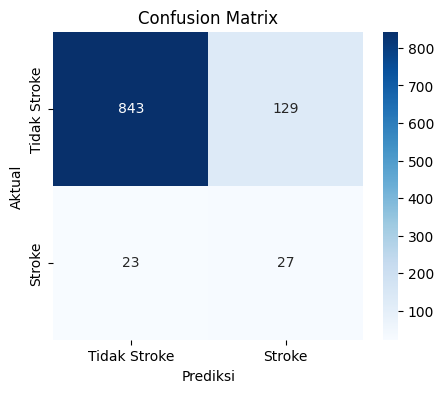

In [ ]:

# --- CONFUSION MATRIX ---
cm = confusion_matrix(yte, pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak Stroke', 'Stroke'],
            yticklabels=['Tidak Stroke', 'Stroke'])

plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()


Confusion matrix tersebut menunjukkan performa model dalam memprediksi apakah seseorang mengalami stroke atau tidak. Pada bagian aktual = Tidak Stroke, model berhasil mengklasifikasikan 843 data dengan benar (True Negative), namun masih salah memprediksi 129 data sebagai stroke (False Positive). Sementara itu, pada bagian aktual = Stroke, model mampu mendeteksi 27 kasus stroke dengan benar (True Positive), namun meloloskan 23 kasus stroke yang diprediksi sebagai tidak stroke (False Negative).

Secara keseluruhan, model menunjukkan kemampuan yang baik dalam mengenali kelas mayoritas (Tidak Stroke), tetapi masih menghadapi tantangan dalam mendeteksi kasus stroke karena jumlah data stroke yang jauh lebih sedikit. Kesalahan berupa False Negative (23 kasus) perlu diperhatikan karena dalam konteks kesehatan, gagal mendeteksi pasien stroke dapat berisiko lebih besar dibandingkan memprediksi stroke pada pasien yang sebenarnya sehat.

## CONTOH DATA BARU

In [ ]:
new_data = pd.DataFrame({
    'age': [45],
    'avg_glucose_level': [120.5],
    'bmi': [27.5],
    'risk_score': [0],                     # hypertension + heart_disease
    'gender': ['Male'],
    'ever_married': ['Yes'],
    'work_type': ['Private'],
    'Residence_type': ['Urban'],
    'smoking_status': ['never smokes'],
    'glucose_category': ['Diabetes'],
    'age_group': ['Adult']
})
# Gunakan preprocessor yang sama seperti waktu training
new_processed = preprocessor.transform(new_data)
# Pastikan bentuknya sesuai (dense)
def ensure_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

new_dense = ensure_dense(new_processed).astype("float32")

# === PREDIKSI ===
proba = model.predict(new_dense).ravel()
pred = (proba >= 0.5).astype(int)

print("Probabilitas stroke:", proba)
print("Prediksi (0 = Tidak Stroke, 1 = Stroke):", pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Probabilitas stroke: [0.38474083]
Prediksi (0 = Tidak Stroke, 1 = Stroke): [0]


In [ ]:
new_data = pd.DataFrame({
    'age': [72],
    'avg_glucose_level': [250],
    'bmi': [34],
    'risk_score': [2],
    'gender': ['Male'],
    'ever_married': ['Yes'],
    'work_type': ['Private'],
    'Residence_type': ['Urban'],
    'smoking_status': ['smokes'],

    'glucose_category': ['Diabetes'],
    'age_group': ['Senior']
})
# Gunakan preprocessor yang sama seperti waktu training
new_processed = preprocessor.transform(new_data)
# Pastikan bentuknya sesuai (dense)
def ensure_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

new_dense = ensure_dense(new_processed).astype("float32")

# === PREDIKSI ===
proba = model.predict(new_dense).ravel()      # probabilitas bertahan hidup
pred = (proba >= 0.5).astype(int)             # 1 = survived, 0 = not survived

print("Probabilitas stroke:", proba)
print("Prediksi (0 = Tidak Stroke, 1 = Stroke):", pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Probabilitas stroke: [0.6877937]
Prediksi (0 = Tidak Stroke, 1 = Stroke): [1]


Kode tersebut digunakan untuk melakukan prediksi terhadap satu data baru dengan struktur fitur yang sama seperti data training. Data baru terlebih dahulu dimasukkan ke dalam sebuah DataFrame kemudian diproses menggunakan preprocessor yang sama agar melalui langkah imputasi, scaling, dan one-hot encoding yang konsisten dengan proses pelatihan model. Setelah diproses, data diubah menjadi bentuk dense menggunakan fungsi ensure_dense() karena model neural network memerlukan input dalam format array numerik penuh. Selanjutnya, model menghasilkan probabilitas terjadinya stroke melalui model.predict(), dan probabilitas tersebut dikonversi menjadi kelas akhir menggunakan threshold 0.5, di mana nilai 0 menunjukkan tidak berisiko stroke dan nilai 1 menunjukkan prediksi stroke. Output menampilkan baik probabilitas maupun hasil prediksi sehingga pengguna dapat melihat tingkat keyakinan model terhadap keputusan yang diberikan.

## GRAFIK HASIL

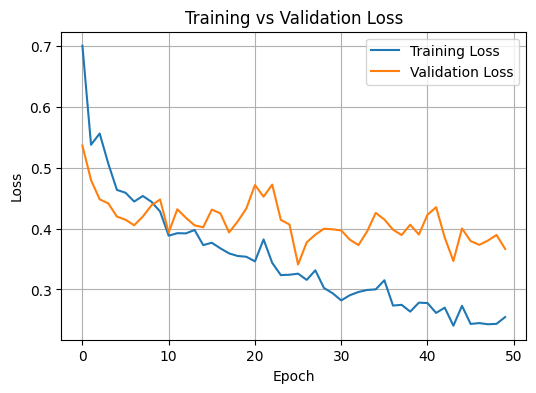

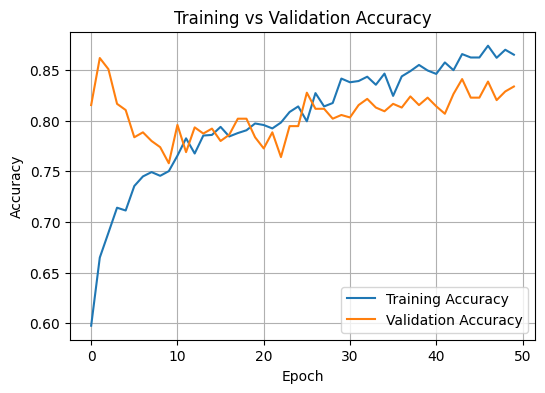

In [ ]:
# ---- GRAFIK LOSS ----
plt.figure(figsize=(6,4))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ---- GRAFIK ACCURACY ----
plt.figure(figsize=(6,4))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Dari grafik Training vs Validation Loss terlihat bahwa nilai loss pada data training terus menurun secara bertahap, menandakan bahwa model semakin mampu mempelajari pola pada data. Sementara itu, loss pada data validation cenderung berfluktuasi di kisaran yang relatif stabil setelah beberapa epoch. Pola ini menunjukkan bahwa model tidak mengalami overfitting secara berat, meskipun terdapat sedikit ketidakstabilan pada validation loss yang umum terjadi pada dataset kecil atau tidak seimbang.

Pada grafik Training vs Validation Accuracy, akurasi training meningkat konsisten hingga melewati 85%, sedangkan akurasi validation bergerak di sekitar 80–83% dan relatif stabil setelah pertengahan epoch. Hal ini menunjukkan bahwa performa model pada data yang tidak dilihat saat training tetap baik dan tidak tertinggal jauh dibandingkan akurasi training. Secara keseluruhan, kedua grafik ini memperlihatkan bahwa proses pelatihan berjalan dengan cukup baik: model berhasil belajar pola tanpa mengalami overfitting yang signifikan, meskipun masih terdapat ruang peningkatan terutama untuk performa pada kelas minoritas.

##ANALISIS HASIL

###INTERPRESTASI HASIL MODEL
Model neural network yang dibangun menunjukkan performa yang cukup baik dalam memprediksi kemungkinan terjadinya stroke. Hal ini terlihat dari nilai akurasi sebesar 85%, serta nilai ROC AUC mendekati 0.80 yang mengindikasikan bahwa model mampu membedakan antara pasien stroke dan tidak stroke secara cukup efektif. Grafik pelatihan juga menunjukkan bahwa proses training berjalan stabil tanpa overfitting yang signifikan, di mana training dan validation accuracy berada pada rentang yang konsisten. Meski demikian, model masih memiliki keterbatasan dalam mendeteksi kelas stroke (kelas minoritas). Nilai recall sebesar 0.54 menunjukkan bahwa model hanya mampu menangkap sekitar separuh dari seluruh kasus stroke, sementara precision yang rendah (0.17) menandakan bahwa sebagian besar prediksi "stroke" masih salah. Kondisi ini mencerminkan tantangan umum pada dataset yang tidak seimbang, di mana jumlah pasien stroke jauh lebih sedikit dibandingkan pasien normal sehingga memengaruhi kualitas prediksi pada kelas minoritas.

### KELEBIHAN MODEL



1.   Kemampuan generalisasi yang baik
Training dan validation accuracy relatif stabil, menunjukkan bahwa model tidak overfitting secara berat dan dapat bekerja dengan baik pada data baru.

2. AUC mendekati 0.8
Nilai ROC AUC yang tinggi menunjukkan model cukup efektif dalam membedakan dua kelas meskipun data bersifat imbalanced.

3. Arsitektur diperkuat dengan BatchNormalization dan Dropout
Kombinasi kedua teknik ini membuat model lebih stabil dan mampu mempelajari fitur non-linear tanpa mengalami overfitting.

4. Menggunakan class weight
Model sudah dilatih dengan mempertimbangkan ketidakseimbangan kelas, sehingga performa kelas minoritas lebih baik dibandingkan model tanpa penyesuaian



## KEKURANGAN MODEL
1. Precision kelas stroke masih rendah
Banyak prediksi stroke yang ternyata salah (false positive), sehingga model belum cukup spesifik dalam mendeteksi pasien yang benar-benar stroke.

2. Recall kelas stroke belum optimal
Meskipun lebih baik daripada random guess, model masih meloloskan sekitar 46% kasus stroke, yang dapat menjadi risiko tinggi dalam konteks medis.

3. Ketergantungan pada data yang tidak seimbang
Ketidakseimbangan jumlah antara pasien stroke dan non-stroke membuat model sulit mempelajari karakteristik kelas minoritas secara mendalam.

4. Dataset terbatas dalam ukuran dan variasi
Jumlah data yang relatif kecil dapat membatasi kemampuan model untuk belajar pola yang lebih kompleks dan akurat.



## MODEL PEMBANDING (LOGSTIC REGRESSION DAN RF)

In [ ]:
# probabilitas stroke
proba_lr = logreg.predict_proba(X_test)[:, 1]

# prediksi kelas
pred_lr = (proba_lr >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, pred_lr))
print("ROC AUC:", roc_auc_score(y_test, proba_lr))
print(confusion_matrix(y_test, pred_lr))
print(classification_report(y_test, pred_lr))


Accuracy: 0.7142857142857143
ROC AUC: 0.8171810699588478
[[693 279]
 [ 13  37]]
              precision    recall  f1-score   support

           0       0.98      0.71      0.83       972
           1       0.12      0.74      0.20        50

    accuracy                           0.71      1022
   macro avg       0.55      0.73      0.51      1022
weighted avg       0.94      0.71      0.80      1022



Kode tersebut digunakan untuk melakukan evaluasi model Logistic Regression pada data uji. Pertama, predict_proba() menghasilkan probabilitas terjadinya stroke untuk setiap sampel, dan nilai probabilitas kelas positif diambil melalui [:, 1]. Probabilitas ini kemudian dikonversi menjadi prediksi kelas menggunakan threshold 0.5, sehingga nilai di atas 0.5 dianggap sebagai stroke dan sebaliknya. Selanjutnya, performa model dievaluasi menggunakan metrik akurasi, ROC AUC, confusion matrix, dan classification report untuk melihat kemampuan model dalam membedakan dua kelas serta kualitas prediksi pada kelas minoritas. Hasil evaluasi ini memungkinkan perbandingan kinerja Logistic Regression dengan model sebelumnya, terutama dalam konteks dataset yang tidak seimbang seperti kasus prediksi stroke.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Random Forest dengan penanganan imbalance
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight={0:1, 1:50},   # penting untuk data imbalance
    random_state=1
)

# Training
rf.fit(ensure_dense(X_train), y_train)

# Prediksi kelas
pred_rf = rf.predict(ensure_dense(X_test))

# Probabilitas (untuk AUC)
proba_rf = rf.predict_proba(ensure_dense(X_test))[:, 1]

print("\n=== MODEL PEMBANDING: RANDOM FOREST ===")
print("Accuracy:", accuracy_score(y_test, pred_rf))
print("ROC AUC :", roc_auc_score(y_test, proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_rf))
print("Classification Report:\n", classification_report(y_test, pred_rf, digits=4))



=== MODEL PEMBANDING: RANDOM FOREST ===
Accuracy: 0.8522504892367906
ROC AUC : 0.7870679012345679
Confusion Matrix:
 [[851 121]
 [ 30  20]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9659    0.8755    0.9185       972
           1     0.1418    0.4000    0.2094        50

    accuracy                         0.8523      1022
   macro avg     0.5539    0.6378    0.5640      1022
weighted avg     0.9256    0.8523    0.8838      1022



Kode tersebut digunakan untuk membangun dan mengevaluasi model pembanding menggunakan Random Forest pada kasus klasifikasi stroke. Model dikonfigurasi dengan 300 pohon keputusan dan kedalaman maksimum 10 untuk menjaga kompleksitas tetap terkontrol. Parameter class_weight={0:1, 1:50} diberikan untuk mengatasi ketidakseimbangan kelas dengan cara memberikan bobot lebih besar pada kelas stroke sehingga model lebih sensitif dalam mendeteksi kasus positif. Setelah model dilatih menggunakan data training, prediksi kelas dan probabilitas pada data uji dihasilkan untuk menghitung berbagai metrik evaluasi, seperti akurasi, ROC AUC, confusion matrix, dan classification report. Hasil evaluasi ini digunakan untuk melihat apakah Random Forest mampu memberikan performa yang lebih baik dibandingkan model sebelumnya, terutama dalam mendeteksi kelas minoritas pada dataset yang tidak seimbang.